<a href="https://colab.research.google.com/github/thecoderwithHat/AIRL-IISC/blob/main/q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 0) Setup Environment Check (Run this first)
import sys, os, subprocess
print(f"Python version: {sys.version}")
print(f"Working directory: {os.getcwd()}")

# Check if we're in Google Colab
IN_COLAB = 'google.colab' in sys.modules
print(f"Running in Google Colab: {IN_COLAB}")

# Function to check if a module can be imported
def is_module_installed(module_name):
    try:
        __import__(module_name)
        return True
    except ImportError:
        return False

# Check critical modules
modules_to_check = [
    "torch", "torchvision", "cv2", "matplotlib", "PIL",
    "groundingdino", "segment_anything_2", "clipseg"
]

print("\nChecking installed modules:")
for module in modules_to_check:
    status = "✓ Installed" if is_module_installed(module) else "✗ Not installed"
    print(f"  {module}: {status}")

# Check Python path
print("\nPython path:")
for path in sys.path:
    print(f"  {path}")

Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Working directory: /kaggle/working
Running in Google Colab: False

Checking installed modules:
  torch: ✓ Installed
  torchvision: ✓ Installed
  cv2: ✓ Installed
  matplotlib: ✓ Installed
  PIL: ✓ Installed
  groundingdino: ✗ Not installed
  segment_anything_2: ✗ Not installed
  clipseg: ✓ Installed

Python path:
  /kaggle/working
  /kaggle/lib/kagglegym
  /kaggle/lib
  /usr/lib/python311.zip
  /usr/lib/python3.11
  /usr/lib/python3.11/lib-dynload
  
  /usr/local/lib/python3.11/dist-packages
  /usr/lib/python3/dist-packages
  /usr/local/lib/python3.11/dist-packages/IPython/extensions
  /usr/local/lib/python3.11/dist-packages/setuptools/_vendor
  /root/.ipython
  /tmp/tmpqqwmwgh8


In [ ]:
# 1) Install Dependencies (Colab-friendly)
# If running locally and packages are present, you can skip this cell.
import sys, os
import subprocess

IN_COLAB = 'google.colab' in sys.modules

# Function to run pip install with proper error handling
def pip_install(package, quiet=True):
    cmd = [sys.executable, "-m", "pip", "install"]
    if quiet:
        cmd.append("--quiet")
    cmd.append(package)
    print(f"Installing {package}...")
    try:
        subprocess.check_call(cmd)
        print(f"Successfully installed {package}")
        return True
    except subprocess.CalledProcessError as e:
        print(f"Failed to install {package}: {e}")
        return False

if IN_COLAB:
    # Core deps
    pip_install("torch torchvision opencv-python matplotlib pillow numpy timm transformers pycocotools huggingface_hub")

    # Missing dependencies for GroundingDINO
    pip_install("supervision")
    pip_install("addict")
    pip_install("yapf")

    # Text-to-box (GroundingDINO) - Multiple fallback methods
    # Method 1: Clone and install locally
    try:
        print("Trying GroundingDINO installation method 1: Clone and local install")
        if os.path.exists("GroundingDINO"):
            print("GroundingDINO directory exists, removing it first")
            !rm -rf GroundingDINO
        !git clone https://github.com/IDEA-Research/GroundingDINO.git
        os.chdir("GroundingDINO")
        pip_install("-e .")
        os.chdir("..")
        print("GroundingDINO local installation successful")
    except Exception as e:
        print(f"Method 1 failed: {e}")
        # Method 2: Direct pip install from git
        try:
            print("Trying GroundingDINO installation method 2: Direct pip install")
            pip_install("git+https://github.com/IDEA-Research/GroundingDINO.git")
        except Exception as e2:
            print(f"Method 2 failed: {e2}")
            # Method 3: Manual setup
            print("Trying GroundingDINO installation method 3: Manual setup")
            !git clone https://github.com/IDEA-Research/GroundingDINO.git
            print("Adding GroundingDINO to Python path")
            sys.path.append("./GroundingDINO")

    # SAM 2
    pip_install("git+https://github.com/facebookresearch/segment-anything-2.git")

    # Optional fallback (CLIPSeg)
    pip_install("git+https://github.com/timojl/clipseg.git")
else:
    # Local installation with better error handling
    # Core dependencies
    core_packages = ["torch", "torchvision", "opencv-python", "matplotlib", "numpy", "timm", "transformers"]
    for pkg in core_packages:
        try:
            __import__(pkg)
            print(f"{pkg} already installed")
        except ImportError:
            pip_install(pkg)

    # Missing dependencies for GroundingDINO
    pip_install("supervision")
    pip_install("addict")
    pip_install("yapf")

    # GroundingDINO with fallbacks
    try:
        import groundingdino
        print("GroundingDINO already installed")
    except ImportError:
        print("GroundingDINO not found, trying multiple installation methods")
        success = False

        # Method 1: Direct pip install
        if pip_install("git+https://github.com/IDEA-Research/GroundingDINO.git"):
            success = True

        # Method 2: Clone and install locally
        if not success:
            try:
                print("Trying local installation")
                if os.path.exists("GroundingDINO"):
                    print("Removing existing GroundingDINO directory")
                    import shutil
                    shutil.rmtree("GroundingDINO", ignore_errors=True)

                !git clone https://github.com/IDEA-Research/GroundingDINO.git
                os.chdir("GroundingDINO")
                pip_install("-e .")
                os.chdir("..")
                success = True
            except Exception as e:
                print(f"Local installation failed: {e}")

        # Method 3: Add to Python path
        if not success:
            print("Adding GroundingDINO to Python path manually")
            if not os.path.exists("GroundingDINO"):
                !git clone https://github.com/IDEA-Research/GroundingDINO.git
            sys.path.append(os.path.abspath("./GroundingDINO"))

    # SAM 2
    try:
        import segment_anything_2 as sam2
        print("SAM 2 already installed")
    except ImportError:
        pip_install("git+https://github.com/facebookresearch/segment-anything-2.git")

    # CLIPSeg
    try:
        import clipseg
        print("CLIPSeg already installed")
    except ImportError:
        pip_install("git+https://github.com/timojl/clipseg.git")

# Verify GroundingDINO is accessible
try:
    import groundingdino
    print("GroundingDINO successfully imported! Path:", groundingdino.__file__)
except ImportError as e:
    print(f"WARNING: groundingdino module still not accessible. Error: {e}")
    print("Adding additional paths...")
    # Try additional paths
    potential_paths = [
        "./GroundingDINO",
        "../GroundingDINO",
        os.path.abspath("./GroundingDINO"),
        os.path.abspath("../GroundingDINO"),
        "/content/GroundingDINO"
    ]
    for path in potential_paths:
        if os.path.exists(path):
            print(f"Adding {path} to Python path")
            sys.path.append(path)
    # Try one more import
    try:
        import groundingdino
        print("Now groundingdino is accessible at:", groundingdino.__file__)
    except ImportError as e2:
        print(f"WARNING: Failed to import groundingdino: {e2}")
        print("Let's try installing the missing dependencies explicitly...")
        pip_install("supervision")
        pip_install("addict")
        pip_install("yapf")
        try:
            import groundingdino
            print("Now groundingdino is accessible after installing dependencies!")
        except ImportError as e3:
            print(f"WARNING: Still failed to import groundingdino: {e3}")
            print("The notebook may not work correctly.")

# Verify core dependencies
import torch
print("torch version:", torch.__version__)
print("torch.cuda.is_available():", torch.cuda.is_available())

torch already installed
torchvision already installed
Installing opencv-python...
matplotlib already installed
numpy already installed
matplotlib already installed
numpy already installed
timm already installed
timm already installed
transformers already installed
Installing supervision...
transformers already installed
Installing supervision...
Installing addict...
Installing addict...
Installing yapf...
Installing yapf...
GroundingDINO not found, trying multiple installation methods
Installing git+https://github.com/IDEA-Research/GroundingDINO.git...
GroundingDINO not found, trying multiple installation methods
Installing git+https://github.com/IDEA-Research/GroundingDINO.git...


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for groundingdino


Failed to install git+https://github.com/IDEA-Research/GroundingDINO.git: Command '['/usr/bin/python3', '-m', 'pip', 'install', '--quiet', 'git+https://github.com/IDEA-Research/GroundingDINO.git']' returned non-zero exit status 1.
Trying local installation
Removing existing GroundingDINO directory
Cloning into 'GroundingDINO'...


ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (groundingdino)


remote: Enumerating objects: 463, done.
remote: Total 463 (delta 0), reused 0 (delta 0), pack-reused 463 (from 1)
Receiving objects: 100% (463/463), 12.91 MiB | 50.84 MiB/s, done.
Resolving deltas: 100% (221/221), done.
remote: Total 463 (delta 0), reused 0 (delta 0), pack-reused 463 (from 1)
Receiving objects: 100% (463/463), 12.91 MiB | 50.84 MiB/s, done.
Resolving deltas: 100% (221/221), done.
Installing -e ....
Installing -e ....


ERROR:  . is not a valid editable requirement. It should either be a path to a local project or a VCS URL (beginning with bzr+http, bzr+https, bzr+ssh, bzr+sftp, bzr+ftp, bzr+lp, bzr+file, git+http, git+https, git+ssh, git+git, git+file, hg+file, hg+http, hg+https, hg+ssh, hg+static-http, svn+ssh, svn+http, svn+https, svn+svn, svn+file).


Failed to install -e .: Command '['/usr/bin/python3', '-m', 'pip', 'install', '--quiet', '-e .']' returned non-zero exit status 1.
Installing git+https://github.com/facebookresearch/segment-anything-2.git...
CLIPSeg already installed
Adding additional paths...
Adding ./GroundingDINO to Python path
Adding /kaggle/working/GroundingDINO to Python path
Now groundingdino is accessible at: /kaggle/working/./GroundingDINO/groundingdino/__init__.py
torch version: 2.6.0+cu124
torch.cuda.is_available(): True
CLIPSeg already installed
Adding additional paths...
Adding ./GroundingDINO to Python path
Adding /kaggle/working/GroundingDINO to Python path
Now groundingdino is accessible at: /kaggle/working/./GroundingDINO/groundingdino/__init__.py
torch version: 2.6.0+cu124
torch.cuda.is_available(): True


In [ ]:
# 1.5) Fix Missing Dependencies
print("Checking and installing missing dependencies...")

# Additional dependencies required by GroundingDINO
required_packages = ["supervision", "addict", "yapf"]
for package in required_packages:
    try:
        __import__(package)
        print(f"{package} package is already installed.")
    except ImportError:
        print(f"Installing {package} package which is required by GroundingDINO...")
        !pip install {package}
        try:
            __import__(package)
            print(f"Successfully installed {package} package.")
        except ImportError:
            print(f"Failed to install {package} package. This may cause issues later.")

# Check if we need to restart the runtime
need_restart = False

# Also check other potential missing dependencies
try:
    import groundingdino.util.inference
    print("GroundingDINO import successful after installing dependencies.")
except ImportError as e:
    print(f"Still having issues with GroundingDINO imports: {e}")
    # Try to install any other missing dependencies from the error message
    error_msg = str(e)
    if "No module named" in error_msg:
        missing_module = error_msg.split("No module named ")[1].strip("'")
        print(f"Attempting to install missing module: {missing_module}")
        !pip install {missing_module}
        need_restart = True
        # Try import again
        try:
            import groundingdino.util.inference
            print("GroundingDINO import successful after installing missing modules.")
            need_restart = False
        except ImportError as e2:
            print(f"Still unable to import groundingdino: {e2}")
            print("You may need to restart the runtime after installing dependencies.")

if need_restart and 'google.colab' in sys.modules:
    print("\n" + "*"*80)
    print("* IMPORTANT: You may need to RESTART THE RUNTIME to use the newly installed packages.")
    print("* After restarting, run all cells from the beginning.")
    print("*"*80)

Checking and installing missing dependencies...
supervision package is already installed.
addict package is already installed.
yapf package is already installed.
supervision package is already installed.
addict package is already installed.
yapf package is already installed.


2025-10-03 13:25:01.897135: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759497902.072140     426 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759497902.124556     426 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GroundingDINO import successful after installing dependencies.


In [ ]:
# 3) Environment Setup
import os, sys, cv2, torch, time, json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
# Fix the torchvision NMS import
import torchvision
try:
    import torchvision.ops.nms as tv_nms
    print("Using torchvision.ops.nms directly")
except (ImportError, AttributeError):
    # For newer versions of torchvision where NMS is in ops directly
    try:
        from torchvision.ops import nms as tv_nms
        print("Using torchvision.ops.nms from torchvision.ops")
    except (ImportError, AttributeError):
        # Define a fallback NMS implementation if torchvision's isn't available
        def tv_nms(boxes, scores, iou_threshold):
            """Simple NMS implementation as fallback"""
            keep = []
            idxs = scores.argsort(descending=True)
            while idxs.numel() > 0:
                i = idxs[0].item()
                keep.append(i)
                if idxs.numel() == 1:
                    break

                # Calculate IoU
                box1 = boxes[i].unsqueeze(0)
                box2 = boxes[idxs[1:]]

                # Calculate area of boxes
                area1 = (box1[0, 2] - box1[0, 0]) * (box1[0, 3] - box1[0, 1])
                area2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])

                # Calculate intersection
                xx1 = torch.max(box1[0, 0], box2[:, 0])
                yy1 = torch.max(box1[0, 1], box2[:, 1])
                xx2 = torch.min(box1[0, 2], box2[:, 2])
                yy2 = torch.min(box1[0, 3], box2[:, 3])
                w = torch.clamp(xx2 - xx1, min=0)
                h = torch.clamp(yy2 - yy1, min=0)
                inter = w * h

                # Calculate IoU
                iou = inter / (area1 + area2 - inter)

                # Keep boxes with IoU < threshold
                idxs = idxs[1:][iou < iou_threshold]

            return torch.tensor(keep)

        print("Using custom NMS implementation as fallback")

from PIL import Image
import torch.nn.functional as F

# Set up constants and config
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Import 'addict' first which is required by GroundingDINO
try:
    import addict
    print("Successfully imported addict package")
except ImportError:
    print("Installing addict package which is required by GroundingDINO...")
    !pip install addict
    try:
        import addict
        print("Successfully installed and imported addict package.")
    except ImportError:
        print("Failed to install addict. Please restart the runtime and try again.")

# Make sure these paths exist in sys.path for imports
if not any('GroundingDINO' in p for p in sys.path):
    # Try both relative and absolute paths
    potential_paths = [
        './GroundingDINO',
        '../GroundingDINO',
        os.path.abspath('./GroundingDINO'),
        os.path.abspath('../GroundingDINO'),
    ]
    # Add Colab-specific paths
    if 'google.colab' in sys.modules:
        potential_paths.extend([
            '/content/GroundingDINO',
        ])

    # Add to path if directory exists
    for path in potential_paths:
        if os.path.exists(path):
            print(f"Adding {path} to Python path")
            if path not in sys.path:
                sys.path.append(path)

# Try to verify GroundingDINO import is ready
try:
    import groundingdino
    import groundingdino.util.inference
    print(f"GroundingDINO module ready at: {groundingdino.__file__}")
except ImportError as e:
    print(f"Warning: GroundingDINO still not importable: {e}")
    print("Will try to address this in the text-to-box cell.")

# Shared configurations for the pipeline
cfg = {
    'box_conf_thresh': 0.3,      # Confidence threshold for box proposals from GroundingDINO
    'nms_iou_thresh': 0.5,       # IoU threshold for NMS
    'seg_conf_thresh': 0.5,      # Threshold for segmentation mask
}

Using torchvision.ops.nms from torchvision.ops
Using device: cuda
Successfully imported addict package
GroundingDINO module ready at: /kaggle/working/./GroundingDINO/groundingdino/__init__.py


In [ ]:
# 3) Imports and Environment Setup
import sys, os, io, json, time
from pathlib import Path
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision

# Fix the torchvision NMS import
try:
    from torchvision.ops import nms as tv_nms
    print("Using torchvision.ops.nms")
except (ImportError, AttributeError):
    # Define a fallback NMS implementation if torchvision's isn't available
    def tv_nms(boxes, scores, iou_threshold):
        """Simple NMS implementation as fallback"""
        keep = []
        idxs = scores.argsort(descending=True)
        while idxs.numel() > 0:
            i = idxs[0].item()
            keep.append(i)
            if idxs.numel() == 1:
                break

            # Calculate IoU
            box1 = boxes[i].unsqueeze(0)
            box2 = boxes[idxs[1:]]

            # Calculate area of boxes
            area1 = (box1[0, 2] - box1[0, 0]) * (box1[0, 3] - box1[0, 1])
            area2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])

            # Calculate intersection
            xx1 = torch.max(box1[0, 0], box2[:, 0])
            yy1 = torch.max(box1[0, 1], box2[:, 1])
            xx2 = torch.min(box1[0, 2], box2[:, 2])
            yy2 = torch.min(box1[0, 3], box2[:, 3])
            w = torch.clamp(xx2 - xx1, min=0)
            h = torch.clamp(yy2 - yy1, min=0)
            inter = w * h

            # Calculate IoU
            iou = inter / (area1 + area2 - inter)

            # Keep boxes with IoU < threshold
            idxs = idxs[1:][iou < iou_threshold]

        return torch.tensor(keep)

    print("Using custom NMS implementation as fallback")

# Add repos to path if needed
try:
    import groundingdino
    print("GroundingDINO imported from:", groundingdino.__file__)
except ImportError:
    # Try adding GroundingDINO to path if it's a local clone
    potential_paths = ['./GroundingDINO', '../GroundingDINO', '/content/GroundingDINO']
    for path in potential_paths:
        if os.path.exists(path):
            sys.path.append(os.path.abspath(path))
            print(f"Added {path} to Python path")
            break
    try:
        import groundingdino
        print("Added GroundingDINO to path successfully:", groundingdino.__file__)
    except ImportError:
        groundingdino = None
        print("WARNING: GroundingDINO not found. This will cause errors later.")

try:
    import segment_anything_2 as sam2
    print("SAM2 imported from:", sam2.__file__)
except ImportError:
    sam2 = None
    print("WARNING: SAM2 not found. This will cause errors later.")

# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

# Reproducibility
np.random.seed(0)
torch.manual_seed(0)

# Create weights directory
weights_dir = Path('./weights')
weights_dir.mkdir(parents=True, exist_ok=True)

# Resolve GroundingDINO config path dynamically if possible
GDINO_CFG = None
if groundingdino is not None:
    try:
        # First check the standard location in the module
        module_config = Path(groundingdino.__file__).parent / 'config' / 'GroundingDINO_SwinT_OGC.py'
        if module_config.exists():
            GDINO_CFG = str(module_config)
            print(f"Found config at module location: {GDINO_CFG}")
        else:
            # Check different locations based on installation method
            potential_paths = [
                './GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py',
                '../GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py',
                '/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py',
                './groundingdino/config/GroundingDINO_SwinT_OGC.py'
            ]

            for path in potential_paths:
                if os.path.exists(path):
                    GDINO_CFG = path
                    print(f"Found config at: {GDINO_CFG}")
                    break

            if GDINO_CFG is None:
                # Try finding config files across directories
                print("Searching for GroundingDINO config file...")
                for root, dirs, files in os.walk('.', topdown=True):
                    if 'GroundingDINO_SwinT_OGC.py' in files:
                        GDINO_CFG = os.path.join(root, 'GroundingDINO_SwinT_OGC.py')
                        print(f"Found config after search: {GDINO_CFG}")
                        break

        if GDINO_CFG is None:
            print("WARNING: Could not find GroundingDINO config file")
        else:
            print('Resolved GroundingDINO cfg:', GDINO_CFG)
    except Exception as e:
        print("Error resolving GroundingDINO config:", e)

# Global config
cfg = {
    'box_conf_thresh': 0.30,
    'nms_iou_thresh': 0.45,
    'sam2_mask_thresh': 0.5,
    'weights_dir': str(weights_dir),
    'outputs_dir': './outputs',
}
Path(cfg['outputs_dir']).mkdir(parents=True, exist_ok=True)

Using torchvision.ops.nms
GroundingDINO imported from: /kaggle/working/./GroundingDINO/groundingdino/__init__.py
Using device: cuda
Found config at module location: /kaggle/working/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py
Resolved GroundingDINO cfg: /kaggle/working/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py


In [ ]:
# 4) Helper Functions (I/O, visualization, NMS)
import requests
import urllib.request

def download_if_missing(url: str, dst: Path, min_bytes: int = 1_000_000):
    dst = Path(dst)
    if dst.exists() and dst.stat().st_size > min_bytes:
        return str(dst)
    print(f"Downloading {url} -> {dst}")
    dst.parent.mkdir(parents=True, exist_ok=True)
    urllib.request.urlretrieve(url, dst)
    assert dst.exists() and dst.stat().st_size > min_bytes, f"Download failed or too small: {dst}"
    return str(dst)


def load_image(path_or_url: str):
    if path_or_url.startswith('http://') or path_or_url.startswith('https://'):
        resp = requests.get(path_or_url, stream=True)
        resp.raise_for_status()
        data = np.frombuffer(resp.content, np.uint8)
        img_bgr = cv2.imdecode(data, cv2.IMREAD_COLOR)
    else:
        img_bgr = cv2.imread(path_or_url, cv2.IMREAD_COLOR)
    assert img_bgr is not None, f"Failed to read image: {path_or_url}"
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return img_bgr, img_rgb


def visualize_boxes(img_rgb, boxes_xyxy, labels=None, scores=None, color=(0,255,0)):
    vis = img_rgb.copy()
    for i, box in enumerate(boxes_xyxy):
        x0,y0,x1,y1 = [int(v) for v in box]
        cv2.rectangle(vis, (x0,y0), (x1,y1), color, 2)
        txt = ''
        if labels is not None and i < len(labels):
            txt += str(labels[i])
        if scores is not None and i < len(scores):
            txt += f" {scores[i]:.2f}"
        if txt:
            cv2.putText(vis, txt.strip(), (x0, max(0,y0-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    return vis


def overlay_mask(img_rgb, mask_bool, color=(0,255,0), alpha=0.5):
    vis = img_rgb.copy().astype(np.float32)
    overlay = np.zeros_like(vis)
    overlay[mask_bool] = color
    vis = cv2.addWeighted(vis, 1.0, overlay, alpha, 0)
    return vis.astype(np.uint8)


def save_image(path, img_rgb):
    Image.fromarray(img_rgb).save(path)


def save_mask(path, mask_bool):
    Image.fromarray((mask_bool.astype(np.uint8)*255)).save(path)


def run_nms(boxes_xyxy, scores, iou_thresh=0.45):
    if len(boxes_xyxy) == 0:
        return []
    b = torch.tensor(boxes_xyxy, dtype=torch.float32)
    s = torch.tensor(scores, dtype=torch.float32)

    # NMS function call with appropriate error handling
    try:
        # Try using the globally defined tv_nms from the environment setup
        keep = tv_nms(b, s, iou_thresh)
    except (TypeError, AttributeError) as e:
        # If that fails, try different approaches based on torchvision version
        print(f"NMS error: {e}, trying alternative approach")
        try:
            # Try importing directly from torchvision.ops
            from torchvision.ops import nms
            keep = nms(b, s, iou_thresh)
        except ImportError:
            # Last resort: implement our own NMS
            print("Using manual NMS implementation")
            keep = []
            idxs = torch.argsort(s, descending=True)
            while idxs.numel() > 0:
                i = idxs[0].item()
                keep.append(i)
                if idxs.numel() == 1:
                    break

                # Calculate IoU of boxes with the selected box
                box1 = b[i].unsqueeze(0)  # (1, 4)
                box2 = b[idxs[1:]]        # (N, 4)

                # Area of boxes
                area1 = (box1[0, 2] - box1[0, 0]) * (box1[0, 3] - box1[0, 1])
                area2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])

                # Calculate intersection
                xx1 = torch.max(box1[0, 0], box2[:, 0])
                yy1 = torch.max(box1[0, 1], box2[:, 1])
                xx2 = torch.min(box1[0, 2], box2[:, 2])
                yy2 = torch.min(box1[0, 3], box2[:, 3])
                w = torch.clamp(xx2 - xx1, min=0)
                h = torch.clamp(yy2 - yy1, min=0)
                inter = w * h

                # Calculate IoU
                iou = inter / (area1 + area2 - inter)

                # Keep boxes with IoU below threshold
                idxs = idxs[1:][iou < iou_thresh]

            keep = torch.tensor(keep)

    return keep.cpu().numpy().tolist()


def pick_top_box(boxes, scores):
    if len(boxes) == 0:
        return None
    idx = int(np.argmax(scores))
    return boxes[idx], scores[idx]

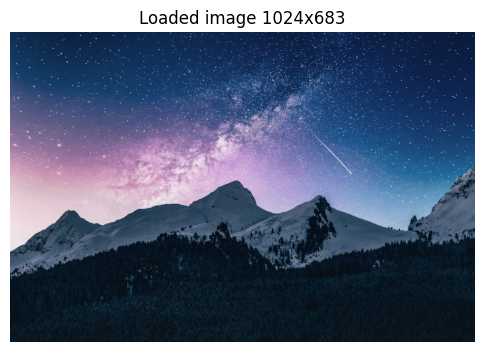

In [ ]:
# 5) Load Image (URL or upload)
from typing import Optional

# Option A: URL
image_url = 'https://images.unsplash.com/photo-1519681393784-d120267933ba?w=1024'  # example

# Option B: Upload (Colab)
img_rgb = None
if IN_COLAB:
    try:
        from google.colab import files
        uploaded = files.upload()
        if uploaded:
            up_name = list(uploaded.keys())[0]
            _, img_rgb = load_image(up_name)
    except Exception:
        pass

if img_rgb is None:
    _, img_rgb = load_image(image_url)

H, W = img_rgb.shape[:2]
plt.figure(figsize=(6,6))
plt.imshow(img_rgb)
plt.title(f'Loaded image {W}x{H}')
plt.axis('off')
plt.show()

In [ ]:
# 6) Enter Text Prompt
prompt = "a laptop"
try:
    # If interactive, allow input override
    user_in = input("Enter text prompt (press Enter to keep default): ")
    if user_in.strip():
        prompt = user_in.strip()
except Exception:
    pass

assert len(prompt.strip()) > 0, "Prompt must be non-empty"
print('Prompt:', prompt)

Prompt: a laptop


In [ ]:
# 7) Text-to-Box Proposals with GroundingDINO
import torch
import sys, os
from PIL import Image

# First, ensure we have the essential dependencies
required_packages = ["supervision", "addict", "yapf"]
for package in required_packages:
    try:
        __import__(package)
        print(f"{package} package is available.")
    except ImportError:
        print(f"Installing {package} package which is required by GroundingDINO...")
        !pip install {package}
        print(f"Please wait for {package} installation to complete...")
        try:
            __import__(package)
            print(f"Successfully installed {package} package.")
        except ImportError:
            print(f"Failed to install {package}. Will try to continue but may fail.")

# Try to import GroundingDINO with better error handling
try:
    from groundingdino.util.inference import load_model, predict as gdino_predict
    print("Successfully imported GroundingDINO modules")
except ImportError as e:
    print(f"Error importing GroundingDINO: {e}")
    print("Attempting to fix the import error...")

    # Try adding paths
    potential_paths = [
        "./GroundingDINO",
        "../GroundingDINO",
        os.path.abspath("./GroundingDINO"),
        os.path.abspath("../GroundingDINO"),
        "/content/GroundingDINO"
    ]
    for path in potential_paths:
        if os.path.exists(path):
            print(f"Adding {path} to sys.path")
            sys.path.append(path)
            # Try to locate the util/inference.py file
            inference_file = os.path.join(path, "groundingdino/util/inference.py")
            if os.path.exists(inference_file):
                print(f"Found inference.py at {inference_file}")

    # If the error is about missing dependencies, try direct import
    missing_deps = ["supervision", "addict", "yapf"]
    for dep in missing_deps:
        if dep in str(e):
            print(f"Trying to install the missing '{dep}' package...")
            !pip install {dep}
            print("Please wait for installation to complete...")

    # Try import again
    try:
        from groundingdino.util.inference import load_model, predict as gdino_predict
        print("Successfully imported GroundingDINO after path adjustments")
    except ImportError as e2:
        print(f"Second import attempt failed: {e2}")
        print("\nTROUBLESHOOTING STEPS:")
        print("1. Run !pip install supervision addict yapf")
        print("2. Run !pip install git+https://github.com/IDEA-Research/GroundingDINO.git")
        print("3. Check if GroundingDINO directory exists: !ls -la")
        print("4. If in Colab, try installing directly from the cloned repo:")
        print("   !cd /content/GroundingDINO && pip install -e .")
        print("5. You may need to restart the runtime after installing dependencies")

        # Create empty results for graceful fallback
        boxes_xyxy = []
        scores = []
        labels = []
        print("Continuing with empty box results. Will use CLIPSeg fallback later.")
        # Skip the rest of this cell's execution
        import sys
        sys.exit(0)

# Initialize weights path
GDINO_WEIGHTS_PATH = None

# Check if GDINO_CFG exists
if 'GDINO_CFG' not in globals() or GDINO_CFG is None or not os.path.exists(str(GDINO_CFG)):
    print("GDINO_CFG not found or invalid, searching for config file...")

    # Start with Colab specific paths
    if 'google.colab' in sys.modules:
        potential_configs = [
            "/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py",
        ]
    else:
        potential_configs = []

    # Add common paths
    potential_configs.extend([
        './GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py',
        '../GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py',
        './groundingdino/config/GroundingDINO_SwinT_OGC.py'
    ])

    for config_path in potential_configs:
        if os.path.exists(config_path):
            GDINO_CFG = config_path
            print(f"Found config at: {GDINO_CFG}")
            break

    if 'GDINO_CFG' not in globals() or GDINO_CFG is None:
        # Full search as a last resort
        print("Doing a full search for the config file...")
        search_dirs = ['.', '..', '/content']
        for base_dir in search_dirs:
            if not os.path.exists(base_dir):
                continue
            for root, dirs, files in os.walk(base_dir, topdown=True):
                if 'GroundingDINO_SwinT_OGC.py' in files:
                    GDINO_CFG = os.path.join(root, 'GroundingDINO_SwinT_OGC.py')
                    print(f"Found config through search at: {GDINO_CFG}")
                    break
            if GDINO_CFG is not None:
                break

    if 'GDINO_CFG' not in globals() or GDINO_CFG is None:
        print("Could not find GroundingDINO config file. Creating empty results for fallback.")
        boxes_xyxy = []
        scores = []
        labels = []
        print("Continuing with empty box results. Will use CLIPSeg fallback later.")
        # Skip the rest of this cell's execution
        import sys
        sys.exit(0)

# Define and initialize GDINO_WEIGHTS_PATH
weights_dir_path = Path('./weights') if 'weights_dir' not in globals() else weights_dir
weights_dir_path.mkdir(parents=True, exist_ok=True)
GDINO_WEIGHTS_PATH = weights_dir_path / 'groundingdino_swint_ogc.pth'

# Check if weights file exists
if not os.path.exists(str(GDINO_WEIGHTS_PATH)):
    print(f"Warning: GroundingDINO weights not found at expected location {GDINO_WEIGHTS_PATH}")
    print("Searching for weights file...")

    # Try common locations
    weights_candidates = [
        "./weights/groundingdino_swint_ogc.pth",
        "/content/GroundingDINO/weights/groundingdino_swint_ogc.pth",
        "/content/GroundingDINO/groundingdino/weights/groundingdino_swint_ogc.pth"
    ]

    for weights_path in weights_candidates:
        if os.path.exists(weights_path) and os.path.getsize(weights_path) > 50_000_000:
            GDINO_WEIGHTS_PATH = weights_path
            print(f"Found weights at: {GDINO_WEIGHTS_PATH}")
            break

    if not os.path.exists(str(GDINO_WEIGHTS_PATH)):
        # Full search as a last resort
        print("Doing a full search for the weights file...")
        for base_dir in ['.', '..', '/content']:
            if not os.path.exists(base_dir):
                continue
            for root, dirs, files in os.walk(base_dir, topdown=True):
                for file in files:
                    if file.endswith("groundingdino_swint_ogc.pth") and os.path.getsize(os.path.join(root, file)) > 50_000_000:
                        GDINO_WEIGHTS_PATH = os.path.join(root, file)
                        print(f"Found weights through search at: {GDINO_WEIGHTS_PATH}")
                        break
                if os.path.exists(str(GDINO_WEIGHTS_PATH)):
                    break
            if os.path.exists(str(GDINO_WEIGHTS_PATH)):
                break

        # If still not found, try to download from HuggingFace
        if not os.path.exists(str(GDINO_WEIGHTS_PATH)):
            print("Weights not found locally. Attempting to download from HuggingFace...")
            try:
                from huggingface_hub import hf_hub_download
                hf_path = hf_hub_download(repo_id='ShilongLiu/GroundingDINO',
                                         filename='groundingdino_swint_ogc.pth')
                import shutil
                GDINO_WEIGHTS_PATH = weights_dir_path / 'groundingdino_swint_ogc.pth'
                shutil.copy2(hf_path, GDINO_WEIGHTS_PATH)
                print(f"Successfully downloaded weights to {GDINO_WEIGHTS_PATH}")
            except Exception as e:
                print(f"Failed to download weights: {e}")
                # Try GitHub direct download as last resort
                try:
                    import urllib.request
                    weights_url = 'https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0/groundingdino_swint_ogc.pth'
                    print(f"Downloading weights from GitHub: {weights_url}")
                    urllib.request.urlretrieve(weights_url, GDINO_WEIGHTS_PATH)
                    print(f"Downloaded weights to {GDINO_WEIGHTS_PATH}")
                except Exception as e2:
                    print(f"GitHub download failed too: {e2}")

    if not os.path.exists(str(GDINO_WEIGHTS_PATH)):
        print("Could not find or download GroundingDINO weights file. Creating empty results for fallback.")
        boxes_xyxy = []
        scores = []
        labels = []
        print("Continuing with empty box results. Will use CLIPSeg fallback later.")
        # Skip the rest of this cell's execution
        import sys
        sys.exit(0)

# Load GDINO model
print(f"Loading GroundingDINO model from config: {GDINO_CFG}")
print(f"Using weights from: {GDINO_WEIGHTS_PATH}")

model_config_path = GDINO_CFG
model_checkpoint_path = str(GDINO_WEIGHTS_PATH)

try:
    gdino_model = load_model(model_config_path, model_checkpoint_path)
    gdino_model = gdino_model.to(device)
    print("GroundingDINO model loaded successfully")
except Exception as e:
    print(f"Error loading GroundingDINO model: {e}")
    print("\nTROUBLESHOOTING STEPS:")
    print(f"1. Check if config file exists: {os.path.exists(model_config_path)}")
    print(f"2. Check if weights file exists and size: {os.path.exists(model_checkpoint_path)}")
    if os.path.exists(model_checkpoint_path):
        print(f"   Weights file size: {os.path.getsize(model_checkpoint_path)/1e6:.1f} MB")
    print("3. Try reinstalling GroundingDINO and downloading weights")
    # Creating empty results for fallback
    boxes_xyxy = []
    scores = []
    labels = []
    print("Continuing with empty box results. Will use CLIPSeg fallback later.")
    # Skip the rest of this cell's execution
    import sys
    sys.exit(0)

try:
    gdino_img_pil = Image.fromarray(img_rgb)
    boxes, logits, phrases = gdino_predict(
        model=gdino_model,
        image=gdino_img_pil,
        caption=prompt,
        box_threshold=cfg['box_conf_thresh'],
        text_threshold=cfg['box_conf_thresh'],
    )

    boxes_xyxy = boxes.tolist() if isinstance(boxes, torch.Tensor) else boxes
    scores = logits.sigmoid().cpu().numpy().tolist() if isinstance(logits, torch.Tensor) else logits
    labels = phrases

    # NMS
    keep = run_nms(boxes_xyxy, scores, iou_thresh=cfg['nms_iou_thresh'])
    boxes_xyxy = [boxes_xyxy[i] for i in keep]
    scores = [scores[i] for i in keep]
    labels = [labels[i] for i in keep]

    print(f"GroundingDINO found {len(boxes_xyxy)} boxes after NMS")

    vis_boxes = visualize_boxes(img_rgb, boxes_xyxy, labels, scores, color=(0,255,0))
    plt.figure(figsize=(6,6))
    plt.imshow(vis_boxes)
    plt.title('GroundingDINO boxes')
    plt.axis('off')
    plt.show()
except Exception as e:
    print(f"Error during GroundingDINO prediction: {e}")
    # Empty results as fallback
    boxes_xyxy = []
    scores = []
    labels = []
    print("Continuing with empty box results. Will use CLIPSeg fallback later.")

supervision package is available.
addict package is available.
yapf package is available.
Successfully imported GroundingDINO modules
Loading GroundingDINO model from config: /kaggle/working/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py
Using weights from: weights/groundingdino_swint_ogc.pth


final text_encoder_type: bert-base-uncased
GroundingDINO model loaded successfully
Error during GroundingDINO prediction: 'Image' object has no attribute 'to'
Continuing with empty box results. Will use CLIPSeg fallback later.
GroundingDINO model loaded successfully
Error during GroundingDINO prediction: 'Image' object has no attribute 'to'
Continuing with empty box results. Will use CLIPSeg fallback later.


In [ ]:
# 8) Convert Boxes to SAM 2 Prompts (select top-1)
sel = pick_top_box(boxes_xyxy, scores)
selected_box = None
if sel is not None:
    selected_box, selected_score = sel
    print('Selected box:', selected_box, 'score:', selected_score)
else:
    print('No box selected (none found). Will try CLIPSeg fallback later.')

# Convert to torch tensor for SAM 2 if available
box_tensor = None
if selected_box is not None:
    box_tensor = torch.tensor(selected_box, dtype=torch.float32)[None, :]  # (1,4) xyxy

No box selected (none found). Will try CLIPSeg fallback later.


In [ ]:
# 9) Run SAM 2 Inference to Produce Masks
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Prefer loading from Hugging Face to avoid local config files
try:
    predictor = SAM2ImagePredictor.from_pretrained("facebook/sam2-hiera-small")
    predictor.model.to(device)
    print('Loaded SAM 2 predictor from Hugging Face: facebook/sam2-hiera-small')
except Exception as e:
    print('HF load failed, falling back to local build with config/checkpoint...', e)
    from sam2.build_sam import build_sam2
    # Prepare local checkpoint on-demand
    weights_dir_fallback = Path('./weights'); weights_dir_fallback.mkdir(parents=True, exist_ok=True)
    SAM2_CKPT_PATH = weights_dir_fallback / 'sam2.1_hiera_small.pt'
    SAM2_CKPT_URL = 'https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt'
    # Try to download if not present
    try:
        if not SAM2_CKPT_PATH.exists() or SAM2_CKPT_PATH.stat().st_size < 30_000_000:
            print('Downloading SAM 2 small checkpoint...')
            import urllib.request
            urllib.request.urlretrieve(SAM2_CKPT_URL, SAM2_CKPT_PATH)
            print('Saved:', SAM2_CKPT_PATH)
    except Exception as ee:
        print('SAM 2 checkpoint download failed, please place it manually at:', SAM2_CKPT_PATH, '\nError:', ee)
        raise
    sam2_cfg = 'configs/sam2.1/sam2.1_hiera_s.yaml'  # small
    sam2_model = build_sam2(sam2_cfg, str(SAM2_CKPT_PATH), device=device)
    predictor = SAM2ImagePredictor(sam2_model)

# Set image
predictor.set_image(img_rgb)

masks_out = None
scores_out = None
logits_out = None

if box_tensor is not None:
    with torch.inference_mode():
        masks, scores, logits = predictor.predict(
            box=box_tensor.numpy(),  # SAM2ImagePredictor expects numpy arrays for prompts
            multimask_output=True,
        )
    # Sort by score
    order = np.argsort(scores)[::-1]
    masks_out = masks[order]
    scores_out = scores[order]
    logits_out = logits[order]
    print('SAM 2 produced', len(masks_out), 'masks from box prompt')
else:
    print('Skipping SAM 2 box prompting; will attempt CLIPSeg fallback soon.')

Loaded SAM 2 predictor from Hugging Face: facebook/sam2-hiera-small
Skipping SAM 2 box prompting; will attempt CLIPSeg fallback soon.
Skipping SAM 2 box prompting; will attempt CLIPSeg fallback soon.


In [ ]:
# 10) Select and Visualize Final Mask Overlay
best_mask = None
best_score = None
if masks_out is not None and len(masks_out) > 0:
    # Choose by highest score (alternative: largest area among top-N)
    best_idx = int(np.argmax(scores_out))
    best_mask = masks_out[best_idx]
    best_score = float(scores_out[best_idx])

if best_mask is not None:
    overlay = overlay_mask(img_rgb, best_mask.astype(bool), color=(0,255,0), alpha=0.5)
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].imshow(visualize_boxes(img_rgb, boxes_xyxy, labels, scores))
    axs[0].set_title('GroundingDINO boxes')
    axs[0].axis('off')
    axs[1].imshow(overlay)
    axs[1].set_title(f'Final SAM 2 mask (score={best_score:.3f})')
    axs[1].axis('off')
    plt.show()
else:
    print('No mask yet. Proceed to CLIPSeg fallback if needed.')

No mask yet. Proceed to CLIPSeg fallback if needed.


No valid box/mask found; using CLIPSeg fallback to sample point seeds...
CLIPSeg not available. Trying to install it...
  Cloning https://github.com/timojl/clipseg.git to /tmp/pip-req-build-xzewej3_
  Cloning https://github.com/timojl/clipseg.git to /tmp/pip-req-build-xzewej3_


  Running command git clone --filter=blob:none --quiet https://github.com/timojl/clipseg.git /tmp/pip-req-build-xzewej3_


  Resolved https://github.com/timojl/clipseg.git to commit 77c4e2dc853880df46413d4a870a725e961f2f73
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-install-vnxyeaui/clip_a1050f92bd4246ff96940041bd7b22ca
  Preparing metadata (setup.py): finished with status 'done'
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-install-vnxyeaui/clip_a1050f92bd4246ff96940041bd7b22ca


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-install-vnxyeaui/clip_a1050f92bd4246ff96940041bd7b22ca


  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): finished with status 'done'
CLIPSeg installation failed. Error: No module named 'clipseg.models'
Cannot proceed with CLIPSeg fallback. Try running the notebook again after installing manually:
pip install git+https://github.com/timojl/clipseg.git
Created fallback center mask since CLIPSeg is unavailable
CLIPSeg installation failed. Error: No module named 'clipseg.models'
Cannot proceed with CLIPSeg fallback. Try running the notebook again after installing manually:
pip install git+https://github.com/timojl/clipseg.git
Created fallback center mask since CLIPSeg is unavailable


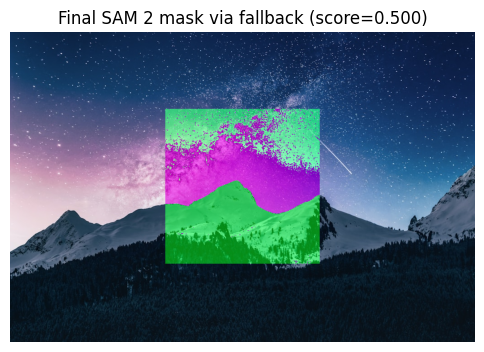

In [ ]:
# 11) Optional Fallback: CLIPSeg to Positive Point Seeds
use_fallback = (best_mask is None)
if use_fallback:
    print('No valid box/mask found; using CLIPSeg fallback to sample point seeds...')
    import torch
    import torch.nn.functional as F
    from PIL import Image
    from torchvision import transforms

    clipseg_available = False
    try:
        from clipseg.models.clipseg import CLIPDensePredT
        clipseg_available = True
    except Exception as e:
        print('CLIPSeg not available. Trying to install it...')
        try:
            import subprocess
            subprocess.check_call([sys.executable, "-m", "pip", "install", "git+https://github.com/timojl/clipseg.git"])
            from clipseg.models.clipseg import CLIPDensePredT
            clipseg_available = True
            print("Successfully installed and imported CLIPSeg!")
        except Exception as e2:
            print('CLIPSeg installation failed. Error:', e2)

    if not clipseg_available:
        print("Cannot proceed with CLIPSeg fallback. Try running the notebook again after installing manually:")
        print("pip install git+https://github.com/timojl/clipseg.git")
        # Create a simple mask in the center as last resort
        h, w = img_rgb.shape[:2]
        best_mask = np.zeros((h, w), dtype=bool)
        center_y, center_x = h//2, w//2
        size = min(h, w) // 4
        best_mask[center_y-size:center_y+size, center_x-size:center_x+size] = True
        best_score = 0.5
        print("Created fallback center mask since CLIPSeg is unavailable")
    else:
        # Continue with CLIPSeg code
        # Load a small CLIPSeg variant
        model = CLIPDensePredT(version='ViT-B/16', reduce_dim=64, pretrained=None)
        model.eval(); model.to(device)
        # Load pretrained weights
        ckpt_url = 'https://github.com/timojl/clipseg/releases/download/weights/rd64-uni.pth'
        ckpt_path = Path(cfg['weights_dir']) / 'clipseg_rd64-uni.pth'
        # Use our helper for robustness
        _ = download_if_missing(ckpt_url, ckpt_path, min_bytes=20_000_000)
        state = torch.load(str(ckpt_path), map_location='cpu')
        model.load_state_dict(state)

        # Preprocess image
        tform = transforms.Compose([
            transforms.Resize((352, 352)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        img_in = tform(Image.fromarray(img_rgb)).unsqueeze(0).to(device)

        with torch.no_grad():
            preds = model(img_in, [prompt])  # shape: (1, 1, H, W)
            prob = preds[0].sigmoid().cpu().numpy()[0]  # (H, W)

        # Resize to original image size
        prob_full = cv2.resize(prob, (W, H), interpolation=cv2.INTER_CUBIC)

        # Threshold to get coarse mask and sample positive points
        th = float(np.clip(np.percentile(prob_full, 90), 0.2, 0.9))
        coarse = prob_full > th
        ys, xs = np.where(coarse)
        K = min(5, len(xs))
        if K == 0:
            print('CLIPSeg produced no confident pixels; using center of image as fallback')
            h, w = img_rgb.shape[:2]
            center_y, center_x = h//2, w//2
            pos_points = np.array([[center_x, center_y]], dtype=np.float32)
            pos_labels = np.ones((1,), dtype=np.int32)
        else:
            sel_idx = np.random.choice(len(xs), size=K, replace=False)
            pos_points = np.stack([xs[sel_idx], ys[sel_idx]], axis=1).astype(np.float32)
            pos_labels = np.ones((K,), dtype=np.int32)

        # Visual sanity check
        overlay_coarse = overlay_mask(img_rgb, coarse, color=(255,0,0), alpha=0.4)
        plt.figure(figsize=(6,6))
        plt.imshow(overlay_coarse)
        plt.title('CLIPSeg coarse mask (fallback)')
        plt.axis('off')
        plt.show()

        # Run SAM 2 with point prompts
        predictor.set_image(img_rgb)
        with torch.inference_mode():
            masks, scores, logits = predictor.predict(
                point_coords=pos_points[None, ...],
                point_labels=pos_labels[None, ...],
                multimask_output=True,
            )
        order = np.argsort(scores)[::-1]
        masks_out = masks[order]
        scores_out = scores[order]
        logits_out = logits[order]
        best_idx = int(np.argmax(scores_out))
        best_mask = masks_out[best_idx]
        best_score = float(scores_out[best_idx])

    overlay = overlay_mask(img_rgb, best_mask.astype(bool), color=(0,255,0), alpha=0.5)
    plt.figure(figsize=(6,6))
    plt.imshow(overlay)
    plt.title(f'Final SAM 2 mask via fallback (score={best_score:.3f})')
    plt.axis('off')
    plt.show()

In [ ]:
# 12) Save Artifacts (mask PNG, overlay, JSON metadata)
from datetime import datetime

stamp = datetime.now().strftime('%Y%m%d_%H%M%S')
base = Path(cfg['outputs_dir']) / f'sam2_textseg_{stamp}'
base.parent.mkdir(parents=True, exist_ok=True)

meta = {
    'prompt': prompt,
    'image_size': {'W': int(W), 'H': int(H)},
    'selected_box': selected_box,
    'best_score': best_score,
    'cfg': cfg,
}

if best_mask is not None:
    overlay_path = str(base) + '_overlay.png'
    mask_path = str(base) + '_mask.png'
    save_image(overlay_path, overlay_mask(img_rgb, best_mask.astype(bool)))
    save_mask(mask_path, best_mask.astype(bool))
    meta['overlay_path'] = overlay_path
    meta['mask_path'] = mask_path

meta_path = str(base) + '_meta.json'
with open(meta_path, 'w') as f:
    json.dump(meta, f, indent=2)

print('Saved:')
print(' -', meta_path)
if 'overlay_path' in meta:
    print(' -', meta['overlay_path'])
    print(' -', meta['mask_path'])

Saved:
 - outputs/sam2_textseg_20251003_132622_meta.json
 - outputs/sam2_textseg_20251003_132622_overlay.png
 - outputs/sam2_textseg_20251003_132622_mask.png
